## Introduction

In this assignment, I will scrape the Wikipedia page (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) to obtain the data that is in the table of postal codes and transform the data into a pandas dataframeand. Then, I read Geospatial_Coordinates.csv file to get their equivalent latitude and longitude values. After that, I will get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. I will use the k-means clustering algorithm to complete this task. Finally, I will use the Folium library to visualize the results.

In [1]:
#Import library
import pandas as pd
import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import numpy as np
from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors

import folium # map rendering library


## Read data from Wikipedia

In [2]:
website_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
df_list = pd.read_html(website_url) 
df_list
df = df_list[0]
df

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,NaN
176,M6Z,Not assigned,NaN
177,M7Z,Not assigned,NaN
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


Only process the cells that have an assigned borough. Ignore cells with a borough that is **Not assigned**

In [3]:
df.drop(df[df['Borough']=='Not assigned'].index,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 2 to 178
Data columns (total 3 columns):
Postal Code     103 non-null object
Borough         103 non-null object
Neighborhood    103 non-null object
dtypes: object(3)
memory usage: 3.2+ KB


Check whether more than one neighborhood can exist in one postal code area.

In [4]:
len(df['Postal Code'].unique())

103

No postal code is listed twice. Print the rows of the dataframe.

In [5]:
print('The dataframe has {} rows'.format(df.shape[0]))

The dataframe has 103 rows


Read latidute and Longitude data from the csv file 

In [6]:
df_coor = pd.read_csv("Geospatial_Coordinates.csv")
df_coor.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Create dataframe with all information: Postal Code,Borough,Neighborhood,Latitude,Longitude.

In [7]:
df_all=df.merge(df_coor,how="inner")
df_all

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


## Explore and cluster the neighborhoods in Toronto

Data will be filtered only boroughs that contain the word Toronto.

In [8]:
df_Toronto = df_all[df_all['Borough'].str.contains("Toronto")]
df_Toronto.reset_index(inplace=True)
df_Toronto.head()

,index,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,19,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [9]:
print('The Toronto dataframe has {} venues'.format(df_Toronto.shape[0]))

The Toronto dataframe has 39 venues


Read data from Foursquare to get categories from each venue  (radius=500, limit=100)

In [10]:
CLIENT_ID = '412TMQN1E2PPHSBKHPTVT2RVG1TPUZ3YJGMDWTJLEYI1AFPR' # your Foursquare ID
CLIENT_SECRET = 'MZFNLK0F1OEP3CPVRQABCJ5I4LZDIM2CLBPGKC2ZDIJ0RZWC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius = 500
LIMIT = 100


In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        #print( requests.get(url).json())
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    nearby_venues
    return(nearby_venues)

In [12]:
toronto_venues = getNearbyVenues(names=df_Toronto['Neighborhood'],
                                   latitudes=df_Toronto['Latitude'],
                                   longitudes=df_Toronto['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

In [13]:
print(toronto_venues.shape)

(1604, 7)


In [14]:
toronto_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,55,55,55,55,55,55
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",18,18,18,18,18,18
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",14,14,14,14,14,14
Central Bay Street,65,65,65,65,65,65


In [15]:
print('There are {} uniques categories in nearby Toronto.'.format(len(toronto_venues['Venue Category'].unique())))

There are 237 uniques categories in nearby Toronto.


#### Cleaning data, update similar categories to decrease categories in data. 

In [16]:
idx=toronto_venues[(toronto_venues['Venue Category']=='Café')|(toronto_venues['Venue Category']=='Coffee Shop')].index
toronto_venues.loc[idx,'Venue Category'] ='Coffee Shop'

In [17]:
idx=toronto_venues[(toronto_venues['Venue Category'].str.contains("Pub")) | (toronto_venues['Venue Category'].str.contains("Bar"))].index
toronto_venues.loc[idx,'Venue Category'] ='Pub'

In [18]:
idx=toronto_venues[toronto_venues['Venue Category'].str.contains("Restaurant")].index
toronto_venues.loc[idx,'Venue Category'] ='Restaurant'

In [19]:
idx=toronto_venues[toronto_venues['Venue Category'].str.contains("Food")].index
toronto_venues.loc[idx,'Venue Category'] ='Food'

In [20]:
idx=toronto_venues[toronto_venues['Venue Category'].str.contains("Theater")].index
toronto_venues.loc[idx,'Venue Category'] ='Theater'

In [21]:
idx=toronto_venues[toronto_venues['Venue Category'].str.contains("Airport")].index
toronto_venues.loc[idx,'Venue Category'] ='Airport'

#### Processing data before apply k-Means clustering algorithm.

In [22]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Airport,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,Auto Workshop,BBQ Joint,...,Tanning Salon,Tea Room,Theater,Toy / Game Store,Trail,Train Station,Video Game Store,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
toronto_onehot.shape

(1604, 171)

In [24]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Airport,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,Auto Workshop,...,Tanning Salon,Tea Room,Theater,Toy / Game Store,Trail,Train Station,Video Game Store,Wine Shop,Wings Joint,Women's Store
0,Berczy Park,0.000000,0.0,0.0,0.0,0.018182,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Business reply mail Processing Centre, South C...",0.055556,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.055556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.5,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Central Bay Street,0.015385,0.0,0.0,0.0,0.000000,0.015385,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
toronto_grouped.shape

(39, 171)

In [26]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
         venue  freq
0   Restaurant  0.22
1          Pub  0.15
2  Coffee Shop  0.11
3  Cheese Shop  0.04
4       Bakery  0.04


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0     Coffee Shop  0.23
1      Restaurant  0.09
2  Breakfast Spot  0.09
3             Gym  0.05
4         Stadium  0.05


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
         venue  freq
0   Restaurant  0.11
1  Yoga Studio  0.06
2       Garden  0.06
3   Comic Shop  0.06
4         Park  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                 venue  freq
0              Airport  0.50
1      Harbor / Marina  0.07
2                 Food  0.07
3          Coffee Shop  0.07
4  Rental Car Location  0.07


----Central Bay Street----
            venue  freq
0      Restaurant  0.29
1     Coffee Shop  0.22
2  Sandwich Place  0.05
3             Pub 

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [28]:

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Restaurant,Pub,Coffee Shop,Cheese Shop,Bakery,Grocery Store,Museum,Breakfast Spot,Park,Concert Hall
1,"Brockton, Parkdale Village, Exhibition Place",Coffee Shop,Restaurant,Breakfast Spot,Grocery Store,Bakery,Pet Store,Convenience Store,Climbing Gym,Nightclub,Pub
2,"Business reply mail Processing Centre, South C...",Restaurant,Yoga Studio,Farmers Market,Comic Shop,Pizza Place,Butcher,Recording Studio,Burrito Place,Brewery,Skate Park
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport,Boutique,Food,Boat or Ferry,Harbor / Marina,Coffee Shop,Sculpture Garden,Rental Car Location,Distribution Center,Discount Store
4,Central Bay Street,Restaurant,Coffee Shop,Sandwich Place,Burger Joint,Salad Place,Ice Cream Shop,Pub,Dessert Shop,Bubble Tea Shop,Comic Shop


## Clustering data using k-Means

In [29]:

# set number of clusters
kclusters = 7

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 3, 0, 0, 0, 0, 0, 2])

In [30]:
# add clustering labels
if 'Cluster Labels' in neighborhoods_venues_sorted.columns:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1,inplace=True)

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_Toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,index,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Restaurant,Park,Pub,Bakery,Theater,Breakfast Spot,Electronics Store,Hotel,Ice Cream Shop
1,4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Restaurant,Pub,Yoga Studio,Bank,College Cafeteria,College Auditorium,Creperie,Burrito Place,Sandwich Place
2,9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Restaurant,Coffee Shop,Clothing Store,Pub,Bubble Tea Shop,Cosmetics Shop,Theater,Tea Room,Diner,Hotel
3,15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Restaurant,Coffee Shop,Pub,Gastropub,Cosmetics Shop,Gym,Theater,Hotel,Clothing Store,Lingerie Store
4,19,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Trail,Pub,Food,Women's Store,Cupcake Shop,Distribution Center,Discount Store,Diner,Dessert Shop,Department Store


#### Display map with clustered data:
    - Cluster = 0 : most common venue is Coffee Shop  
    - Cluster = 1 : most common venue is Restaurant
    - Cluster = 2 : most common venue is Playground	
    - Cluster = 3 : is combination of Trail, Park, Restaurant, Food, Pub	
    - Cluster = 4 : most common venue is Airport
    - Cluster = 5 : is combination of Park, Playground , Swim School	
    - Cluster = 6 : most common venue is Health & Beauty Service

In [31]:

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#print(rainbow[0])
#print(colors_array)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    a=int(np.nan_to_num(cluster))
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color= rainbow[a],
        fill=True,
        fill_color=rainbow[a],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [32]:
# The value count for each cluster labels
toronto_merged['Cluster Labels'].value_counts()

0    29
2     5
6     1
5     1
4     1
3     1
1     1
Name: Cluster Labels, dtype: int64

**Result as image**

<div class="output_subarea output_png"><img src="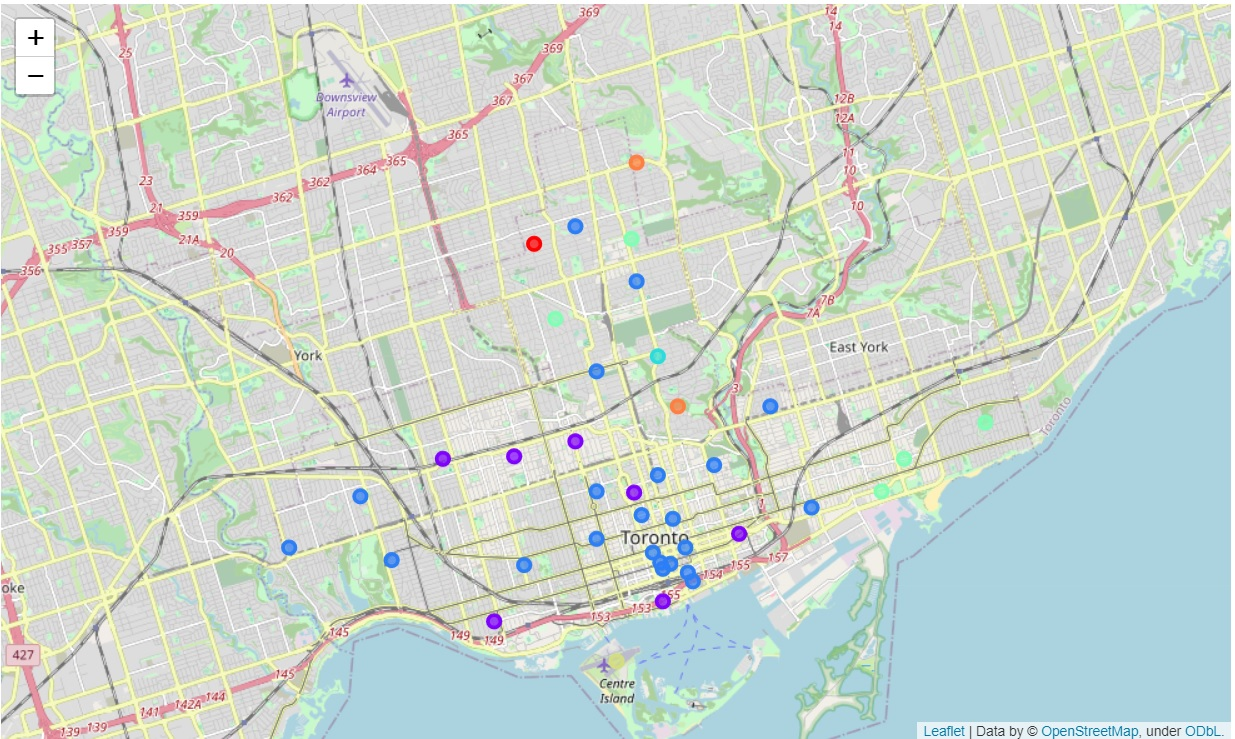
"></div>
